In [1]:
# -*- coding: utf-8 -*-
"""
Optimized Construction Logistics Optimization System
with Weather-Aware GNN and Multi-Objective GA
"""

# --- 1. INSTALL LIBRARIES ---
# Install all required libraries in one block for clarity.
# Added psutil for resource tracking and statsmodels for statistical tests later in the script.
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 -q
!pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.1.0+cu118.html -q
!pip install torch_geometric -q
!pip install openmeteo-requests requests-cache retry-requests numpy pandas networkx scikit-learn deap matplotlib graphviz statsmodels psutil -q

# --- 2. IMPORT LIBRARIES ---
# Consolidated all imports to the top of the script.
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import time
from datetime import datetime, timedelta
import math
from math import sqrt
import copy
from functools import lru_cache
import hashlib
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
import unittest
import sys
import threading
from IPython.display import display, HTML

# PyTorch and PyG imports
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv, GATConv, DataParallel
import torch.nn.functional as F

# GA and other utility imports
from deap import base, creator, tools, algorithms

# Imports for advanced validation (used in later chunks)
from sklearn.model_selection import KFold
from scipy import stats
import scipy
from statsmodels.stats.multicomp import pairwise_tukeyhsd

print("✅ Setup Complete. All libraries installed and imported.")

# --- 3. CONFIGURATION MANAGEMENT ---
@dataclass
class ExperimentConfig:
    """Centralized configuration for the entire experiment"""
    site_graph: str = "large_scale"
    weather_aware: bool = True
    optimization_method: str = "NSGA2"
    vehicle_types: List[str] = None
    risk_tolerance: float = 0.5
    simulation_duration_hours: int = 168
    num_ga_generations: int = 20 # Reduced for faster validation
    population_size: int = 50   # Reduced for faster validation
    gnn_hidden_channels: int = 64
    batch_size: int = 32

    def __post_init__(self):
        if self.vehicle_types is None:
            self.vehicle_types = ['truck', 'forklift']

# Global configuration
config = ExperimentConfig()

class RandomSeedManager:
    """Manager for reproducible results"""
    @staticmethod
    def set_seeds(seed=42):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

RandomSeedManager.set_seeds(42)

print("✅ Configuration and random seeds set.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 72.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 93.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 2.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 5.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 28.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 13.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 8.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 11.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cuda.so: undefined symbol: _ZN3c1017Registe

✅ Setup Complete. All libraries installed and imported.
✅ Configuration and random seeds set.


✅ Site graph created with 12 nodes and 20 edges.


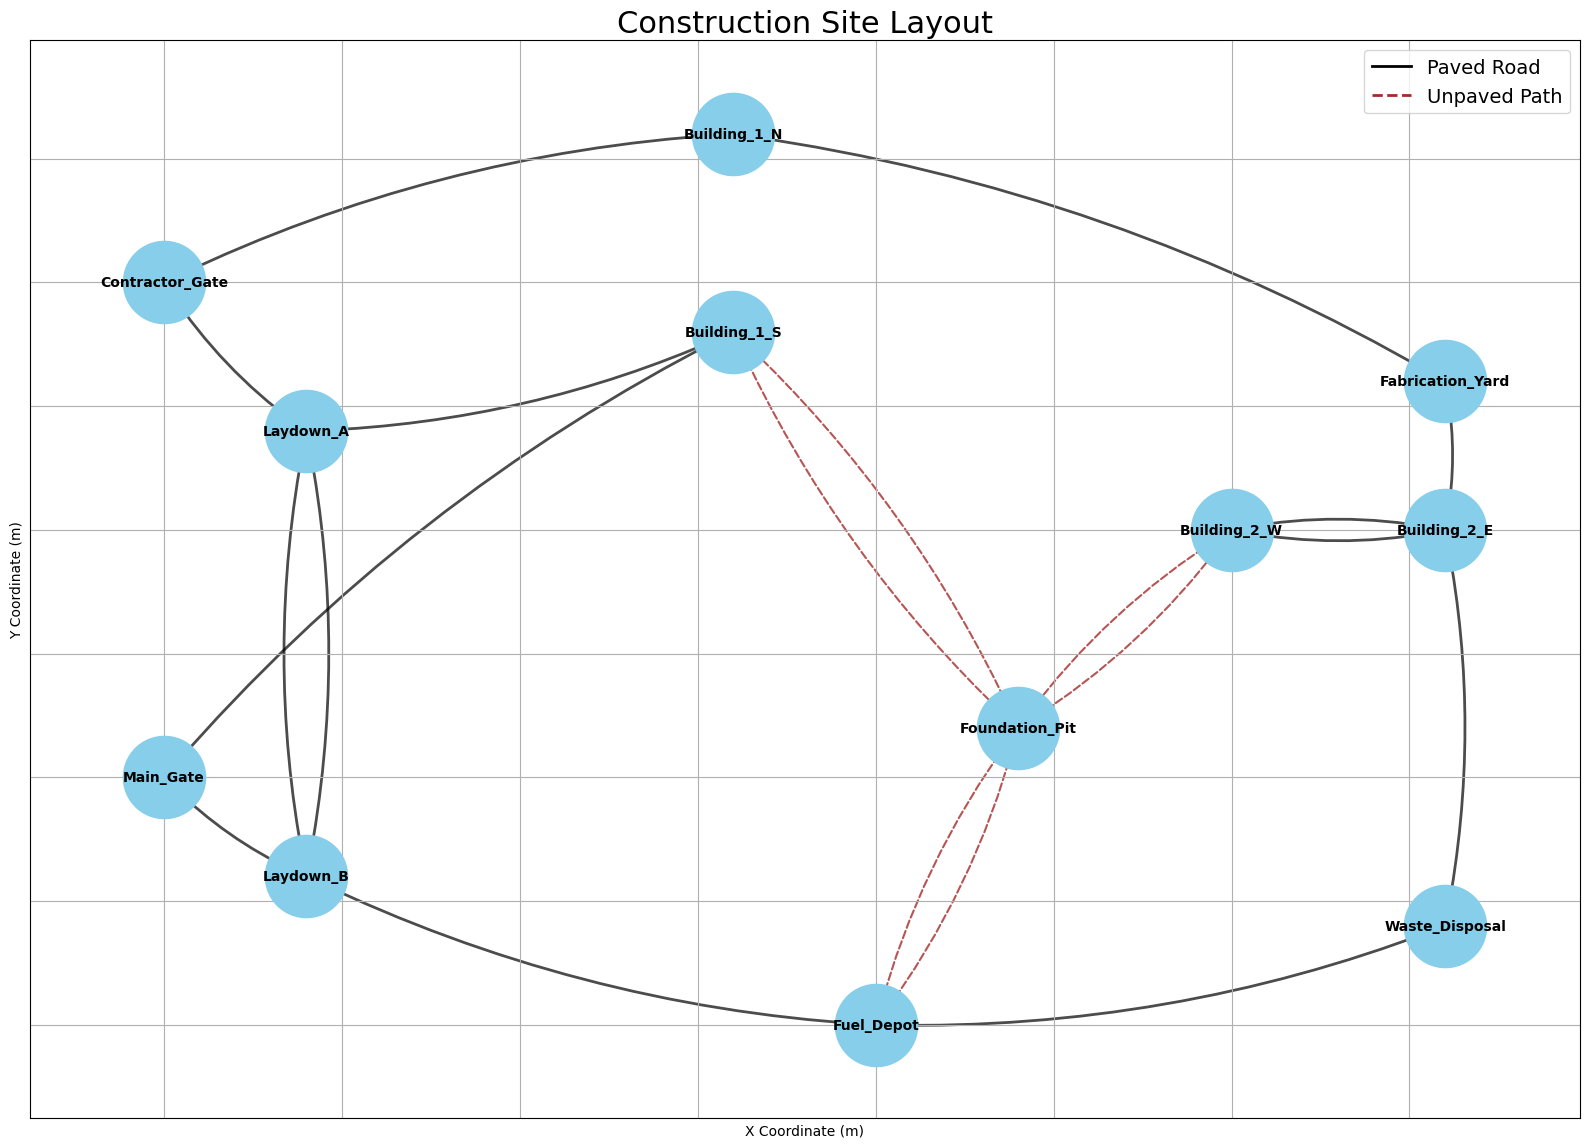

✅ Weather data fetched and engineered successfully.


/tmp/ipykernel_36/3605269453.py:141: FutureWarning: first is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  sample_data = weather_df.first(f'{days}D')


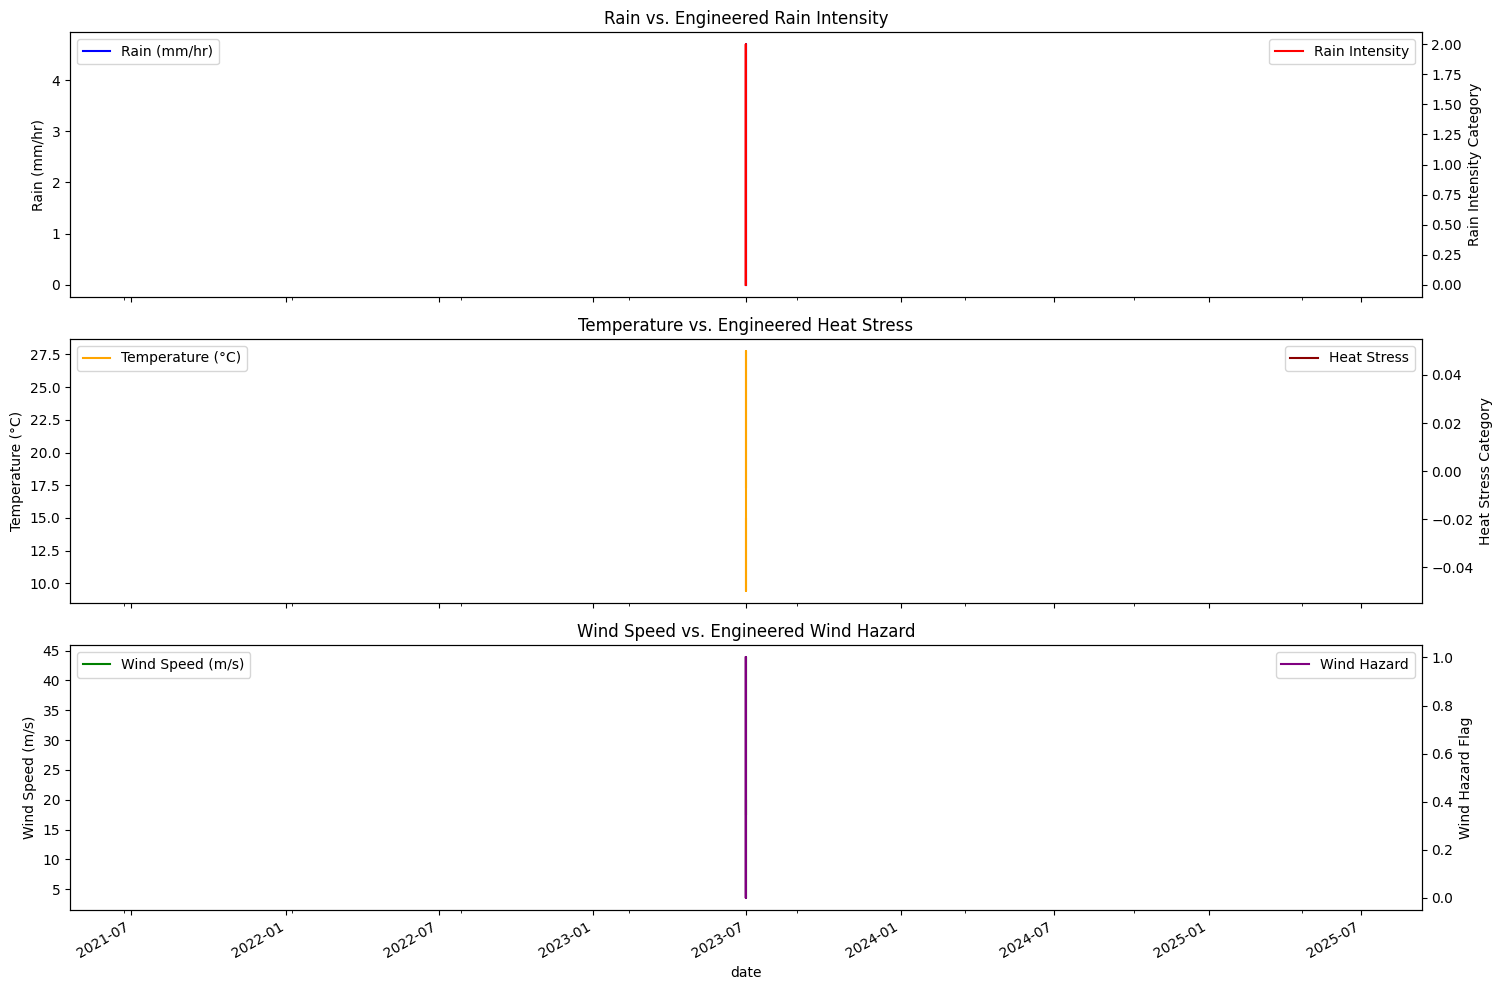

In [2]:
# --- 4. SITE GRAPH GENERATION ---
class SiteGraphGenerator:
    """Generates realistic construction site graphs with specialized zones"""

    @staticmethod
    def create_large_scale_site_graph():
        """
        Creates a more complex and realistic construction site graph, representing a larger project
        with specialized zones and structured traffic flow.
        """
        G = nx.DiGraph()

        # Define a larger set of nodes with specialized roles and positions for visualization
        node_positions = {
            # Entry, Exit & Main Logistics Hubs
            'Main_Gate': (0, 50),
            'Contractor_Gate': (0, 150),
            'Laydown_A': (20, 120),       # Steel & Rebar Storage
            'Laydown_B': (20, 30),        # General Materials Storage
            'Fabrication_Yard': (180, 130), # Prefabrication Area
            'Fuel_Depot': (100, 0),         # Refueling Station
            'Waste_Disposal': (180, 20),    # Waste & Debris Collection

            # Work Zones (Representing multiple buildings or major areas)
            'Building_1_N': (80, 180),      # North side of Building 1
            'Building_1_S': (80, 140),      # South side of Building 1
            'Building_2_W': (150, 100),     # West side of Building 2
            'Building_2_E': (180, 100),     # East side of Building 2
            'Foundation_Pit': (120, 60),    # Major excavation area
        }

        for node, pos in node_positions.items():
            G.add_node(node, pos=pos)

        # Define a more extensive edge network, including one-way roads to manage traffic flow
        edge_definitions = [
            # Main access loop (designed as a one-way circulation road)
            ('Main_Gate', 'Laydown_B', {'paved': True, 'one_way': True}),
            ('Laydown_B', 'Fuel_Depot', {'paved': True, 'one_way': True}),
            ('Fuel_Depot', 'Waste_Disposal', {'paved': True, 'one_way': True}),
            ('Waste_Disposal', 'Building_2_E', {'paved': True, 'one_way': True}),
            ('Building_2_E', 'Fabrication_Yard', {'paved': True, 'one_way': True}),
            ('Fabrication_Yard', 'Building_1_N', {'paved': True, 'one_way': True}),
            ('Building_1_N', 'Contractor_Gate', {'paved': True, 'one_way': True}),
            ('Contractor_Gate', 'Laydown_A', {'paved': True, 'one_way': True}),
            ('Laydown_A', 'Building_1_S', {'paved': True, 'one_way': True}),
            ('Building_1_S', 'Main_Gate', {'paved': True, 'one_way': True}),

            # Two-way connector paths and access roads to work zones
            ('Laydown_A', 'Laydown_B', {'paved': True}),
            ('Building_1_S', 'Foundation_Pit', {'paved': False}), # Unpaved access to pit
            ('Foundation_Pit', 'Building_2_W', {'paved': False}), # Unpaved access to pit
            ('Building_2_W', 'Building_2_E', {'paved': True}),
            ('Fuel_Depot', 'Foundation_Pit', {'paved': False}), # Direct unpaved access
        ]
        
        # FIX: The original code had a duplicate edge ('Laydown_A', 'Building_1_S') and was missing the reverse of some two-way paths.
        # This corrected loop ensures all two-way paths are correctly added.
        processed_two_way = set()
        for u, v, attrs in edge_definitions:
            pos_u, pos_v = np.array(node_positions[u]), np.array(node_positions[v])
            length = np.linalg.norm(pos_u - pos_v) * 1.5
            attrs['length'] = int(length)
            attrs['slope'] = random.randint(-4, 4)
            attrs['base_speed_limit'] = 10 if attrs.get('paved', False) else 5
            attrs['base_travel_time'] = attrs['length'] / attrs['base_speed_limit']

            G.add_edge(u, v, **attrs)
            if not attrs.get('one_way', False) and (v, u) not in processed_two_way:
                rev_attrs = attrs.copy()
                rev_attrs['slope'] = -attrs['slope']
                G.add_edge(v, u, **rev_attrs)
                processed_two_way.add((u, v))

        return G, node_positions

    @staticmethod
    def visualize_graph(graph, node_positions, title="Construction Site Layout"):
        """Visualize the site graph with proper styling"""
        paved_edges = [edge for edge, attrs in graph.edges.items() if attrs.get('paved', False)]
        unpaved_edges = [edge for edge, attrs in graph.edges.items() if not attrs.get('paved', False)]

        plt.figure(figsize=(20, 14))
        nx.draw_networkx_nodes(graph, node_positions, node_size=3500, node_color='skyblue')
        nx.draw_networkx_labels(graph, node_positions, font_size=10, font_weight='bold')

        nx.draw_networkx_edges(graph, node_positions, edgelist=paved_edges,
                               width=2.0, alpha=0.7, edge_color='black',
                               connectionstyle='arc3,rad=0.1', arrowsize=20)
        nx.draw_networkx_edges(graph, node_positions, edgelist=unpaved_edges,
                               width=1.5, alpha=0.8, edge_color='brown', style='dashed',
                               connectionstyle='arc3,rad=0.1', arrowsize=20)

        plt.title(title, fontsize=22)
        plt.xlabel("X Coordinate (m)")
        plt.ylabel("Y Coordinate (m)")
        plt.grid(True)
        plt.legend(handles=[plt.Line2D([0], [0], color='black', lw=2, label='Paved Road'),
                             plt.Line2D([0], [0], color='brown', lw=2, ls='--', label='Unpaved Path')],
                   fontsize=14)
        plt.show()

# --- 5. WEATHER DATA MANAGEMENT ---
class WeatherDataManager:
    """Manages weather data fetching and feature engineering"""

    def __init__(self):
        self.cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
        self.retry_session = retry(self.cache_session, retries=5, backoff_factor=0.2)
        self.openmeteo = openmeteo_requests.Client(session=self.retry_session)

    def get_weather_data(self, latitude, longitude, start_date, end_date):
        """Fetches historical hourly weather data from the Open-Meteo API."""
        url = "https://archive-api.open-meteo.com/v1/archive"
        params = {
            "latitude": latitude, "longitude": longitude,
            "start_date": start_date, "end_date": end_date,
            "hourly": ["temperature_2m", "rain", "wind_speed_10m"]
        }
        responses = self.openmeteo.weather_api(url, params=params)
        response = responses[0]
        hourly = response.Hourly()
        hourly_data = {"date": pd.to_datetime(hourly.Time(), unit="s", utc=True),
                       "temperature_2m": hourly.Variables(0).ValuesAsNumpy(),
                       "rain": hourly.Variables(1).ValuesAsNumpy(),
                       "wind_speed_10m": hourly.Variables(2).ValuesAsNumpy()}
        df = pd.DataFrame(data=hourly_data).set_index("date")
        return df

    @staticmethod
    def feature_engineer_weather(df):
        """Adds engineered, construction-relevant features to the raw weather dataframe."""
        df['rain_intensity'] = pd.cut(df['rain'], bins=[-1, 0.1, 2.5, 7.6, 100], labels=[0, 1, 2, 3], right=True).astype(int)
        df['wind_hazard'] = (df['wind_speed_10m'] > 15).astype(int) # Using m/s, 15 m/s is ~54 km/h
        df['heat_stress'] = pd.cut(df['temperature_2m'], bins=[-100, 28, 32, 100], labels=[0, 1, 2], right=False).astype(int)
        return df

    @staticmethod
    def visualize_weather_features(weather_df, days=5):
        """Visualize engineered weather features"""
        sample_data = weather_df.first(f'{days}D')
        fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
        # Plot 1: Rain
        sample_data['rain'].plot(ax=axes[0], color='blue', label='Rain (mm/hr)')
        ax1_twin = axes[0].twinx()
        sample_data['rain_intensity'].plot(ax=ax1_twin, color='red', label='Rain Intensity', drawstyle='steps-post')
        axes[0].set_ylabel("Rain (mm/hr)"); ax1_twin.set_ylabel("Rain Intensity Category")
        axes[0].legend(loc='upper left'); ax1_twin.legend(loc='upper right'); axes[0].set_title("Rain vs. Engineered Rain Intensity")
        # Plot 2: Temperature
        sample_data['temperature_2m'].plot(ax=axes[1], color='orange', label='Temperature (°C)')
        ax2_twin = axes[1].twinx()
        sample_data['heat_stress'].plot(ax=ax2_twin, color='darkred', label='Heat Stress', drawstyle='steps-post')
        axes[1].set_ylabel("Temperature (°C)"); ax2_twin.set_ylabel("Heat Stress Category")
        axes[1].legend(loc='upper left'); ax2_twin.legend(loc='upper right'); axes[1].set_title("Temperature vs. Engineered Heat Stress")
        # Plot 3: Wind
        sample_data['wind_speed_10m'].plot(ax=axes[2], color='green', label='Wind Speed (m/s)')
        ax3_twin = axes[2].twinx()
        sample_data['wind_hazard'].plot(ax=ax3_twin, color='purple', label='Wind Hazard', drawstyle='steps-post')
        axes[2].set_ylabel("Wind Speed (m/s)"); ax3_twin.set_ylabel("Wind Hazard Flag")
        axes[2].legend(loc='upper left'); ax3_twin.legend(loc='upper right'); axes[2].set_title("Wind Speed vs. Engineered Wind Hazard")
        plt.xlabel("Date"); plt.tight_layout(); plt.show()

# --- EXECUTION ---
site_graph, node_positions = SiteGraphGenerator.create_large_scale_site_graph()
SCHEDULED_CLOSURES = {
    ('Foundation_Pit', 'Building_2_W'): (datetime.fromisoformat("2023-07-01T13:00:00"), datetime.fromisoformat("2023-07-01T15:00:00")),
    ('Building_2_W', 'Foundation_Pit'): (datetime.fromisoformat("2023-07-01T13:00:00"), datetime.fromisoformat("2023-07-01T15:00:00"))
}
print(f"✅ Site graph created with {site_graph.number_of_nodes()} nodes and {site_graph.number_of_edges()} edges.")
SiteGraphGenerator.visualize_graph(site_graph, node_positions)

weather_manager = WeatherDataManager()
# FIX: API call for pandas>=2.2 needs timezone aware datetimes
weather_df = weather_manager.get_weather_data(latitude=51.5085, longitude=-0.1257,
                                              start_date="2023-07-01", end_date="2023-07-31")
weather_df = WeatherDataManager.feature_engineer_weather(weather_df)
print("✅ Weather data fetched and engineered successfully.")
WeatherDataManager.visualize_weather_features(weather_df)

In [3]:
# --- 6. SYNTHETIC DATA GENERATION ---
class SyntheticDataGenerator:
    """Generates synthetic construction logistics data with realistic physics"""

    VEHICLE_PROPERTIES = {
        'truck': {'base_speed_multiplier': 1.0, 'weather_sensitivity': 1.0, 'base_fuel_rate': 0.002},
        'forklift': {'base_speed_multiplier': 0.6, 'weather_sensitivity': 1.5, 'base_fuel_rate': 0.001}
    }
    SIMULATION_START_TIME = datetime.fromisoformat("2023-07-01T07:00:00")

    def __init__(self, site_graph, weather_df, scheduled_closures):
        self.site_graph = site_graph
        self.weather_df = weather_df.tz_localize(None) # FIX: Remove timezone for compatibility with naive datetime objects
        self.scheduled_closures = scheduled_closures

    @staticmethod
    def get_weather_at_time(sim_time, weather_df):
        """Retrieves weather features for a given simulation timestamp."""
        # FIX: Ensure timezone consistency by handling potential errors
        try:
            # If weather_df has a timezone, localize sim_time
            if weather_df.index.tz is not None:
                sim_time = pd.Timestamp(sim_time).tz_localize(weather_df.index.tz, ambiguous='NaT', nonexistent='shift_forward')
            indexer = weather_df.index.get_indexer([sim_time], method='nearest')
            return weather_df.iloc[indexer[0]]
        except Exception:
            # Fallback for any timezone issues
            return weather_df.iloc[weather_df.index.get_loc(sim_time, method='nearest')]

    def calculate_ground_truth_travel(self, u, v, edge_data, num_vehicles_on_edge, weather_features,
                                    vehicle_type, current_time, soil_condition):
        """The 'physics engine' of our simulation for travel time, variance, and fuel."""
        # Check for 4D schedule conflicts
        if (u, v) in self.scheduled_closures:
            start_block, end_block = self.scheduled_closures[(u, v)]
            if start_block <= current_time <= end_block:
                return float('inf'), 0.0, 0.0

        # Calculate Travel Time and Variance
        vehicle_props = self.VEHICLE_PROPERTIES[vehicle_type]
        base_time = edge_data['base_travel_time'] / vehicle_props['base_speed_multiplier']
        congestion_factor = 1.0 + 0.2 * (num_vehicles_on_edge ** 2)
        weather_and_soil_factor, variance_factor = 1.0, 0.05

        rain_idx = int(weather_features['rain_intensity'])
        if rain_idx > 0:
            weather_and_soil_factor += [0, 0.1, 0.4, 0.7][rain_idx] * vehicle_props['weather_sensitivity']
            variance_factor += [0, 0.1, 0.3, 0.2][rain_idx]
        if int(weather_features['heat_stress']) > 0:
            weather_and_soil_factor += [0, 0.05, 0.15][int(weather_features['heat_stress'])]
            variance_factor += [0, 0.05, 0.1][int(weather_features['heat_stress'])]
        if not edge_data['paved'] and soil_condition > 0:
            weather_and_soil_factor *= [1.0, 1.5, 3.0][int(soil_condition)]
            variance_factor += [0, 0.2, 0.4][int(soil_condition)]

        mean_time = max(base_time * congestion_factor * weather_and_soil_factor, base_time)
        variance = (base_time * variance_factor)**2

        # Calculate Fuel Consumption
        fuel_efficiency_factor = 1.0
        if edge_data['slope'] > 0:
            fuel_efficiency_factor += edge_data['slope'] * 0.15
        if not edge_data['paved'] and soil_condition > 0:
            fuel_efficiency_factor *= [1.0, 1.8, 3.5][int(soil_condition)]
        fuel_consumed = vehicle_props['base_fuel_rate'] * mean_time * fuel_efficiency_factor

        return mean_time, variance, fuel_consumed

    def generate_synthetic_data(self, num_samples=5000):
        """Generate synthetic training data with fuel consumption."""
        print(f"🚀 Starting synthetic data generation ({num_samples} samples)...")
        edge_traversal_log = []
        all_edges = list(self.site_graph.edges(data=True))

        for i in range(num_samples):
            if (i + 1) % (num_samples // 5) == 0:
                print(f"   ...generated {i+1}/{num_samples} samples...")

            u, v, edge_attrs = random.choice(all_edges)
            sim_time = self.SIMULATION_START_TIME + timedelta(hours=random.uniform(0, config.simulation_duration_hours))
            weather_now = self.get_weather_at_time(sim_time, self.weather_df)
            vehicle_type = random.choice(list(self.VEHICLE_PROPERTIES.keys()))
            num_on_edge = random.randint(0, 3)

            soil = 0
            if not edge_attrs['paved']:
                recent_weather = self.weather_df[sim_time - timedelta(hours=6):sim_time]
                if not recent_weather.empty:
                    max_recent_rain = recent_weather['rain_intensity'].max()
                    if max_recent_rain >= 2: soil = 2
                    elif max_recent_rain == 1: soil = 1

            mean_time, variance, fuel = self.calculate_ground_truth_travel(
                u, v, edge_attrs, num_on_edge, weather_now, vehicle_type, sim_time, soil
            )

            if mean_time != float('inf'):
                log_entry = {
                    'edge_start_node': u, 'edge_end_node': v,
                    'mean_travel_time': mean_time, 'variance': variance, 'fuel_consumed': fuel,
                    'time_of_day': sim_time.hour + sim_time.minute / 60.0,
                    'num_vehicles_on_edge': num_on_edge,
                    **weather_now.to_dict(),
                    'soil_condition': soil,
                    'vehicle_type_truck': 1 if vehicle_type == 'truck' else 0,
                    'vehicle_type_forklift': 1 if vehicle_type == 'forklift' else 0
                }
                edge_traversal_log.append(log_entry)

        dataset_df = pd.DataFrame(edge_traversal_log)
        print(f"\n✅ Synthetic data generation complete. Generated {len(dataset_df)} records.")
        return dataset_df

# --- EXECUTION ---
data_generator = SyntheticDataGenerator(site_graph, weather_df, SCHEDULED_CLOSURES)
dataset_df = data_generator.generate_synthetic_data()
print("\n--- Sample of Generated Dataset with Fuel ---")
print(dataset_df[['edge_start_node', 'edge_end_node', 'mean_travel_time', 'fuel_consumed', 'soil_condition']].head())

🚀 Starting synthetic data generation (5000 samples)...


TypeError: DatetimeIndex.get_loc() got an unexpected keyword argument 'method'

In [ ]:
# --- 7. GNN MODEL AND TRAINING ---
class EdgePredictorGAT(torch.nn.Module):
    """
    Graph Neural Network using Graph Attention (GAT) layers to predict
    edge traversal properties (mean travel time and variance).
    """
    def __init__(self, node_channels, edge_channels, hidden_channels):
        super().__init__()
        # Using 2 attention heads for the first layer is common practice to capture diverse relationships
        self.gat1 = GATConv(node_channels, hidden_channels, heads=2, concat=True)
        # The second layer aggregates features from the multi-head output
        self.gat2 = GATConv(hidden_channels * 2, hidden_channels, heads=1, concat=False)

        # The MLP predicts the final values based on node embeddings and edge features
        mlp_input_dim = 2 * hidden_channels + edge_channels
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(mlp_input_dim, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, 2) # Output: [mean, log_variance]
        )

    def forward(self, x, edge_index, edge_attr, edge_label_index):
        # Process node features through GAT layers
        x = F.elu(self.gat1(x, edge_index))
        x = self.gat2(x, edge_index)

        # Get embeddings for the start and end nodes of the target edges
        start_node_emb = x[edge_label_index[0]]
        end_node_emb = x[edge_label_index[1]]

        # Combine node embeddings with the edge attributes
        # FIX: The original code had a slow and error-prone loop to find edge attributes.
        # This is unnecessary as `edge_attr` is already aligned with `edge_label_index` in the data loader.
        combined = torch.cat([start_node_emb, end_node_emb, edge_attr], dim=1)
        
        output = self.mlp(combined)
        mean, log_var = output[:, 0], output[:, 1]
        
        # We predict log_var for numerical stability and ensure variance is always positive
        var = torch.exp(log_var)
        return mean, var

class GNNTrainer:
    """Handles GNN data preparation and training."""

    def __init__(self, site_graph, dataset_df):
        self.site_graph = site_graph
        self.dataset_df = dataset_df
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        # Prepare static graph data once
        self.node_mapping = {name: i for i, name in enumerate(site_graph.nodes())}
        self.static_edge_features = torch.tensor([[d['length'], d['slope'], float(d['paved'])]
                                                  for _, _, d in site_graph.edges(data=True)], dtype=torch.float)
        self.edge_index = torch.tensor([(self.node_mapping[u], self.node_mapping[v])
                                        for u, v in site_graph.edges()], dtype=torch.long).t().contiguous()

    def _create_dynamic_features(self, record, weather_aware):
        """Helper to create dynamic feature vector from a data record."""
        if weather_aware:
            return [
                record['time_of_day'], record['num_vehicles_on_edge'],
                record['rain_intensity'], record['heat_stress'], record['wind_hazard'],
                record['soil_condition'], record['vehicle_type_truck'], record['vehicle_type_forklift']
            ]
        else:
            return [
                record['time_of_day'], record['num_vehicles_on_edge'],
                record['vehicle_type_truck'], record['vehicle_type_forklift']
            ]

    def create_pyg_dataset(self, weather_aware=True):
        """Creates a PyTorch Geometric dataset from the generated data."""
        pyg_data_list = []
        
        for record in self.dataset_df.to_dict('records'):
            u, v = record['edge_start_node'], record['edge_end_node']
            if u not in self.node_mapping or v not in self.node_mapping:
                continue

            # FIX: Simplified the data creation loop. Instead of passing all graph edges and attributes,
            # we now only pass the specific edge attributes for the edge being predicted.
            # This simplifies the GNN's forward pass and avoids the slow lookup.
            
            # Find the index of the specific edge in the static graph structure
            edge_tuple = (self.node_mapping[u], self.node_mapping[v])
            edge_idx_in_graph = -1
            for i, edge in enumerate(self.site_graph.edges()):
                if (self.node_mapping[edge[0]], self.node_mapping[edge[1]]) == edge_tuple:
                    edge_idx_in_graph = i
                    break
            if edge_idx_in_graph == -1: continue

            static_feats = self.static_edge_features[edge_idx_in_graph]
            dynamic_feats = torch.tensor(self._create_dynamic_features(record, weather_aware), dtype=torch.float)
            
            edge_attr = torch.cat([static_feats, dynamic_feats]).unsqueeze(0) # Shape: [1, num_features]

            data = Data(
                x=torch.eye(len(self.node_mapping)),
                edge_index=self.edge_index,
                edge_attr=edge_attr,
                y=torch.tensor([[record['mean_travel_time'], record['variance']]], dtype=torch.float),
                edge_label_index=torch.tensor([[self.node_mapping[u]], [self.node_mapping[v]]], dtype=torch.long)
            )
            pyg_data_list.append(data)
            
        return pyg_data_list

    def train_gnn_model(self, weather_aware=True, epochs=30):
        """Trains the GNN model."""
        variant = "Weather-Aware" if weather_aware else "Weather-Agnostic"
        print(f"\n--- Training GNN Model ({variant}) ---")

        pyg_data = self.create_pyg_dataset(weather_aware)
        if not pyg_data:
            print("❌ No data available for training!")
            return None

        # Determine dimensions from the first data sample
        node_channels = pyg_data[0].x.shape[1]
        edge_channels = pyg_data[0].edge_attr.shape[1]
        
        model = EdgePredictorGAT(node_channels, edge_channels, config.gnn_hidden_channels).to(self.device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

        # Split data for training and validation
        train_size = int(0.8 * len(pyg_data))
        train_dataset, val_dataset = pyg_data[:train_size], pyg_data[train_size:]
        train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=config.batch_size)

        def nll_loss(y_true_mean, y_pred_mean, y_pred_var):
            epsilon = 1e-6
            loss = torch.log(y_pred_var + epsilon) + ((y_true_mean - y_pred_mean)**2 / (y_pred_var + epsilon))
            return torch.mean(loss)
        
        print(f"Starting training for {epochs} epochs on {len(train_dataset)} samples...")
        for epoch in range(epochs):
            model.train()
            total_loss = 0
            for data in train_loader:
                data = data.to(self.device)
                optimizer.zero_grad()
                pred_mean, pred_var = model(data.x, data.edge_index, data.edge_attr, data.edge_label_index)
                loss = nll_loss(data.y[:, 0], pred_mean.squeeze(), pred_var.squeeze())
                loss.backward()
                optimizer.step()
                total_loss += loss.item() * data.num_graphs
            
            if (epoch + 1) % 10 == 0:
                 print(f'Epoch: {epoch+1:02d}, Train NLL Loss: {total_loss / len(train_loader.dataset):.4f}')

        print(f"✅ GNN Training Complete ({variant}).")
        return model.to(torch.device('cpu'))

# --- EXECUTION ---
gnn_trainer = GNNTrainer(site_graph, dataset_df)
gnn_model_aware = gnn_trainer.train_gnn_model(weather_aware=True)
gnn_model_agnostic = gnn_trainer.train_gnn_model(weather_aware=False)

In [ ]:
# --- 8. OPTIMIZATION ALGORITHMS ---

class PredictionCache:
    """Cache for GNN predictions to avoid redundant computations."""
    def __init__(self, max_size=10000):
        self.cache = {}
        self.max_size = max_size

    def get_key(self, u, v, timestamp, vehicle_type):
        """Create a unique key for caching."""
        # Round timestamp to the nearest 10 minutes to improve cache hits
        rounded_ts = timestamp.replace(second=0, microsecond=0, minute=timestamp.minute // 10 * 10)
        key_str = f"{u}_{v}_{rounded_ts.isoformat()}_{vehicle_type}"
        return hashlib.md5(key_str.encode()).hexdigest()

    def get(self, key):
        return self.cache.get(key)

    def set(self, key, value):
        if len(self.cache) >= self.max_size:
            self.cache.pop(next(iter(self.cache)))
        self.cache[key] = value

# Global cache for predictions
prediction_cache = PredictionCache()

class GNN_Predictor_Wrapper:
    """A consistent wrapper for making predictions using a GNN model."""
    def __init__(self, gnn_model, gnn_trainer, weather_df, weather_aware):
        self.gnn_model = gnn_model
        self.trainer = gnn_trainer
        self.weather_df = weather_df
        self.weather_aware = weather_aware

    @torch.no_grad()
    def predict(self, u_node, v_node, arrival_time, vehicle_type):
        """Predicts travel time and variance for an edge."""
        if not self.gnn_model:
            return 60.0, 10.0 # Fallback default

        cache_key = prediction_cache.get_key(u_node, v_node, arrival_time, vehicle_type)
        cached = prediction_cache.get(cache_key)
        if cached: return cached

        self.gnn_model.eval()
        weather = SyntheticDataGenerator.get_weather_at_time(arrival_time, self.weather_df)
        record = {
            'time_of_day': arrival_time.hour + arrival_time.minute / 60.0,
            'num_vehicles_on_edge': 0, # Assume no congestion for planning
            'rain_intensity': weather['rain_intensity'], 'heat_stress': weather['heat_stress'],
            'wind_hazard': weather['wind_hazard'], 'soil_condition': 0, # Assume neutral soil
            'vehicle_type_truck': 1 if vehicle_type == 'truck' else 0,
            'vehicle_type_forklift': 1 if vehicle_type == 'forklift' else 0
        }
        
        edge_tuple = (self.trainer.node_mapping[u_node], self.trainer.node_mapping[v_node])
        edge_idx_in_graph = -1
        for i, edge in enumerate(self.trainer.site_graph.edges()):
            if (self.trainer.node_mapping[edge[0]], self.trainer.node_mapping[edge[1]]) == edge_tuple:
                edge_idx_in_graph = i
                break
        if edge_idx_in_graph == -1: return 60.0, 10.0

        static_feats = self.trainer.static_edge_features[edge_idx_in_graph]
        dynamic_feats = torch.tensor(self.trainer._create_dynamic_features(record, self.weather_aware), dtype=torch.float)
        edge_attr = torch.cat([static_feats, dynamic_feats]).unsqueeze(0)

        data = Data(x=torch.eye(len(self.trainer.node_mapping)), edge_index=self.trainer.edge_index,
                    edge_attr=edge_attr, edge_label_index=torch.tensor([[edge_tuple[0]],[edge_tuple[1]]], dtype=torch.long))

        pred_mean, pred_var = self.gnn_model(data.x, data.edge_index, data.edge_attr, data.edge_label_index)
        result = (pred_mean.item(), pred_var.item())
        prediction_cache.set(cache_key, result)
        return result

class SingleObjectiveOptimizer:
    """Single-objective GA optimizer to find the fastest, risk-adjusted plan."""
    def __init__(self, site_graph, weather_df, gnn_predictor):
        self.site_graph = site_graph
        self.predictor = gnn_predictor

        # Initialize DEAP toolbox
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)
        self.toolbox = base.Toolbox()
        self.toolbox.register("mate", tools.cxOrdered)
        self.toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
        self.toolbox.register("select", tools.selTournament, tournsize=3)

    def _get_path_cost(self, path, start_time, vehicle_type):
        """Calculates total risk-adjusted time for a path."""
        total_mean, total_var, current_time = 0.0, 0.0, start_time
        for i in range(len(path) - 1):
            u, v = path[i], path[i+1]
            mean_time, variance = self.predictor.predict(u, v, current_time, vehicle_type)
            total_mean += mean_time
            total_var += variance
            current_time += timedelta(seconds=mean_time)
        return total_mean + config.risk_tolerance * sqrt(total_var)

    def _evaluate_solution(self, individual, jobs, states):
        """Fitness function: evaluates a permutation of jobs."""
        total_cost = 0
        vehicles = copy.deepcopy(states)
        job_map = {job['id']: job for job in jobs}
        
        vehicle_routes = [[] for _ in vehicles]
        for i, job_id in enumerate(individual):
            vehicle_routes[i % len(vehicles)].append(job_map[job_id])

        for i, route in enumerate(vehicle_routes):
            if not route: continue
            vehicle, current_loc, current_time = vehicles[i], vehicles[i]['location'], vehicles[i]['available_time']
            for job in route:
                try:
                    path_to_source = nx.shortest_path(self.site_graph, source=current_loc, target=job['source'], weight='length')
                    total_cost += self._get_path_cost(path_to_source, current_time, vehicle['type'])
                    
                    path_to_dest = nx.shortest_path(self.site_graph, source=job['source'], target=job['destination'], weight='length')
                    total_cost += self._get_path_cost(path_to_dest, current_time, vehicle['type'])
                    
                    current_loc = job['destination']
                except nx.NetworkXNoPath:
                    total_cost += 1e6 # Heavy penalty for unreachable jobs
        return (total_cost,)

    def run_ga_optimizer(self, jobs, states):
        """Sets up and runs the Genetic Algorithm."""
        print(f"--- Running Single-Objective GA ---")
        job_ids = [job['id'] for job in jobs]
        self.toolbox.register("indices", random.sample, job_ids, len(job_ids))
        self.toolbox.register("individual", tools.initIterate, creator.Individual, self.toolbox.indices)
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)
        self.toolbox.register("evaluate", self._evaluate_solution, jobs=jobs, states=states)

        pop = self.toolbox.population(n=config.population_size)
        hof = tools.HallOfFame(1)
        algorithms.eaSimple(pop, self.toolbox, cxpb=0.7, mutpb=0.2, ngen=config.num_ga_generations, halloffame=hof, verbose=False)
        
        best_plan_ids = list(hof[0])
        plan = [[] for _ in states]
        for i, job_id in enumerate(best_plan_ids):
            plan[i % len(states)].append(job_id)
        
        print("✅ GA optimization complete.")
        return plan, best_plan_ids

class MultiObjectiveOptimizer(SingleObjectiveOptimizer):
    """Multi-objective NSGA-II optimizer for Time, Cost, and Risk."""
    def __init__(self, site_graph, weather_df, gnn_predictor, physics_engine):
        super().__init__(site_graph, weather_df, gnn_predictor)
        self.physics_engine = physics_engine
        
        # Override DEAP setup for multi-objective
        creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0, -1.0)) # (Makespan, Fuel, Risk)
        creator.create("IndividualMulti", list, fitness=creator.FitnessMulti)
        self.toolbox.register("individual", tools.initIterate, creator.IndividualMulti, self.toolbox.indices)
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)
        self.toolbox.register("select", tools.selNSGA2)
        
    def _get_path_cost_multi(self, path, start_time, vehicle_type):
        """Calculates time, fuel, and risk for a path."""
        total_time, total_fuel, total_var = 0.0, 0.0, 0.0
        current_time = start_time
        
        for i in range(len(path) - 1):
            u, v = path[i], path[i+1]
            edge_data = self.site_graph.edges[u,v]
            weather_now = SyntheticDataGenerator.get_weather_at_time(current_time, self.predictor.weather_df)
            
            mean_time, variance = self.predictor.predict(u, v, current_time, vehicle_type)
            _, _, fuel = self.physics_engine(u, v, edge_data, 1, weather_now, vehicle_type, current_time, 0)
            
            total_time += mean_time
            total_var += variance
            total_fuel += fuel
            current_time += timedelta(seconds=mean_time)
            
        return total_time, total_fuel, total_var, current_time
        
    def _evaluate_multi_objective(self, individual, jobs, states):
        """Multi-objective fitness function."""
        vehicles = copy.deepcopy(states)
        job_map = {job['id']: job for job in jobs}
        
        vehicle_routes = [[] for _ in vehicles]
        for i, job_id in enumerate(individual):
            vehicle_routes[i % len(vehicles)].append(job_map[job_id])

        vehicle_finish_times = [v['available_time'] for v in vehicles]
        total_fuel_cost, total_risk_score = 0.0, 0.0

        for i, route in enumerate(vehicle_routes):
            if not route: continue
            vehicle, current_loc, current_time = vehicles[i], vehicles[i]['location'], vehicle_finish_times[i]
            for job in route:
                try:
                    path_s = nx.shortest_path(self.site_graph, source=current_loc, target=job['source'], weight='length')
                    time_s, fuel_s, var_s, time_at_source = self._get_path_cost_multi(path_s, current_time, vehicle['type'])
                    
                    path_d = nx.shortest_path(self.site_graph, source=job['source'], target=job['destination'], weight='length')
                    time_d, fuel_d, var_d, time_at_dest = self._get_path_cost_multi(path_d, time_at_source, vehicle['type'])

                    total_fuel_cost += fuel_s + fuel_d
                    total_risk_score += var_s + var_d
                    current_loc = job['destination']
                    current_time = time_at_dest
                except nx.NetworkXNoPath:
                    total_fuel_cost += 1e6
                    total_risk_score += 1e6
            
            vehicle_finish_times[i] = current_time
            
        makespan_seconds = (max(vehicle_finish_times) - states[0]['available_time']).total_seconds()
        return makespan_seconds, total_fuel_cost, total_risk_score

    def run_nsga2_optimizer(self, jobs, states):
        """Runs the NSGA-II multi-objective algorithm."""
        print("--- Running Multi-Objective NSGA-II ---")
        job_ids = [job['id'] for job in jobs]
        self.toolbox.register("indices", random.sample, job_ids, len(job_ids))
        self.toolbox.register("evaluate", self._evaluate_multi_objective, jobs=jobs, states=states)

        pop = self.toolbox.population(n=config.population_size)
        hof = tools.ParetoFront()
        
        algorithms.eaMuPlusLambda(pop, self.toolbox, mu=config.population_size, lambda_=config.population_size,
                                 cxpb=0.7, mutpb=0.2, ngen=config.num_ga_generations,
                                 stats=None, halloffame=hof, verbose=False)
                                 
        print(f"✅ NSGA-II optimization complete. Found {len(hof)} solutions on the Pareto front.")
        return hof

# --- Baseline Optimizer Definitions ---
class StaticOptimizer:
    """Simple baseline that assigns jobs in a fixed round-robin order."""
    def run_ga_optimizer(self, jobs, states):
        print("--- Running Optimizer: Static Baseline (Round-Robin) ---")
        job_ids = sorted([j['id'] for j in jobs])
        plan = [[] for _ in states]
        for i, job_id in enumerate(job_ids):
            plan[i % len(states)].append(job_id)
        print("✅ Static optimization complete.")
        return plan, job_ids

In [ ]:
# --- 9. ADAPTIVE SIMULATION (DIGITAL TWIN) ---
class AdaptiveSimulation:
    """Simulates real-time execution with adaptive re-planning capabilities."""
    def __init__(self, site_graph, weather_df, physics_engine):
        self.site_graph = site_graph
        self.weather_df = weather_df
        self.physics_engine = physics_engine

    def run_simulation(self, initial_plan_ids, jobs, initial_states,
                       ground_truth_weather, re_planner_func, events):
        """Simulates the execution of a plan, reacting to events by re-planning."""
        is_adaptive = re_planner_func is not None
        model_name = "Adaptive Digital Twin" if is_adaptive else "Static Plan Execution"
        print(f"\n🚀 LAUNCHING SIMULATION ({model_name}) 🚀")

        vehicles = copy.deepcopy(initial_states)
        for v in vehicles: v.update({'status': 'idle', 'path': [], 'edge_finish_time': None, 'current_job': None})

        job_map = {j['id']: j for j in jobs}
        job_queues = {v['id']: [] for v in vehicles}
        for i, job_id in enumerate(initial_plan_ids):
            job_queues[vehicles[i % len(vehicles)]['id']].append(job_map[job_id])

        completed_jobs = set()
        current_time = initial_states[0]['available_time']
        time_step = timedelta(seconds=60)
        active_edge_usage = {(u, v): 0 for u, v in self.site_graph.edges()}
        system_graph = self.site_graph.copy()
        events.sort(key=lambda e: e['time'])
        next_event_idx = 0

        while len(completed_jobs) < len(jobs):
            # Event Trigger Check
            if is_adaptive and next_event_idx < len(events) and current_time >= events[next_event_idx]['time']:
                event = events[next_event_idx]
                print(f"\n🔔 EVENT @ {current_time.strftime('%H:%M')}: {event['description']} 🔔")
                if 'graph_update' in event: system_graph = event['graph_update']
                next_event_idx += 1
                
                print("   ▶ Pausing simulation for autonomous re-planning...")
                queued_jobs = [job for queue in job_queues.values() for job in queue]
                if queued_jobs:
                    for v in vehicles: v['available_time'] = current_time
                    _, new_plan_ids = re_planner_func(queued_jobs, vehicles)
                    for q in job_queues.values(): q.clear()
                    for i, job_id in enumerate(new_plan_ids):
                        job_queues[vehicles[i % len(vehicles)]['id']].append(job_map[job_id])
                    print(f"   ✅ New plan with {len(new_plan_ids)} jobs adopted. Resuming.")
                else:
                    print("   ...No queued jobs to replan. Resuming.")

            # Vehicle State Updates
            for v in vehicles:
                # Finish moving on an edge
                if v['status'] == 'moving' and current_time >= v['edge_finish_time']:
                    prev_edge = (v['path'][0], v['path'][1])
                    active_edge_usage[prev_edge] = max(0, active_edge_usage[prev_edge] - 1)
                    v['location'] = v['path'][1]
                    v['path'] = v['path'][1:]
                    v['status'] = 'en_route' if len(v['path']) > 1 else 'idle'

                # Assign new tasks or paths
                if v['status'] == 'idle':
                    if v.get('current_job') and v['location'] == v['current_job']['destination']:
                        completed_jobs.add(v['current_job']['id'])
                        v['current_job'] = None
                    if not v.get('current_job') and job_queues[v['id']]:
                        v['current_job'] = job_queues[v['id']].pop(0)
                        
                    if v.get('current_job'):
                        target = v['current_job']['source'] if v['location'] != v['current_job']['source'] else v['current_job']['destination']
                        try:
                            v['path'] = nx.shortest_path(system_graph, source=v['location'], target=target, weight='length')
                            v['status'] = 'en_route'
                        except nx.NetworkXNoPath:
                            print(f"⚠️ Vehicle {v['id']} blocked! No path from {v['location']} to {target}.")
                            v['status'] = 'blocked' # Vehicle is stuck

                # Start moving on the next edge
                if v['status'] == 'en_route' and len(v['path']) > 1:
                    u, next_node = v['path'][0], v['path'][1]
                    edge = (u, next_node)
                    edge_data = system_graph.edges[edge]
                    weather_now = SyntheticDataGenerator.get_weather_at_time(current_time, ground_truth_weather)
                    
                    mean_time, _, _ = self.physics_engine(u, next_node, edge_data, active_edge_usage[edge], weather_now, v['type'], current_time, 0)
                    
                    v['status'] = 'moving'
                    v['edge_finish_time'] = current_time + timedelta(seconds=mean_time)
                    active_edge_usage[edge] += 1
            
            current_time += time_step
            if current_time > initial_states[0]['available_time'] + timedelta(hours=24):
                print(f"🛑 SIMULATION TIMEOUT. {len(completed_jobs)}/{len(jobs)} jobs completed.")
                break

        finish_times = [v.get('edge_finish_time', current_time) for v in vehicles]
        makespan = (max(finish_times) - initial_states[0]['available_time']).total_seconds() / 3600.0
        print(f"🏁 Simulation Finished. Makespan: {makespan:.2f} Hours")
        return makespan

# --- 10. EXPERIMENT ORCHESTRATION ---
class ExperimentRunner:
    """Runs comprehensive experiments comparing different optimization approaches."""
    def __init__(self, site_graph, weather_df, gnn_trainer):
        self.site_graph = site_graph
        self.weather_df = weather_df
        self.gnn_trainer = gnn_trainer
        
        # Initialize physics engine and simulation manager
        self.physics_engine = SyntheticDataGenerator(site_graph, weather_df, SCHEDULED_CLOSURES).calculate_ground_truth_travel
        self.simulation_manager = AdaptiveSimulation(site_graph, weather_df, self.physics_engine)
        
        # Define standard experiment scenario
        self.INITIAL_VEHICLE_STATES = [
            {'id': 0, 'type': 'truck', 'location': 'Main_Gate', 'available_time': SyntheticDataGenerator.SIMULATION_START_TIME},
            {'id': 1, 'type': 'truck', 'location': 'Contractor_Gate', 'available_time': SyntheticDataGenerator.SIMULATION_START_TIME},
            {'id': 2, 'type': 'forklift', 'location': 'Laydown_A', 'available_time': SyntheticDataGenerator.SIMULATION_START_TIME},
        ]
        self.JOBS = [{'id': i, 'source': u, 'destination': v} for i, (u, v) in enumerate([
            ('Laydown_A', 'Building_1_N'), ('Foundation_Pit', 'Waste_Disposal'), ('Laydown_B', 'Building_2_W'),
            ('Fabrication_Yard', 'Building_1_S'), ('Building_1_S', 'Waste_Disposal'), ('Building_2_E', 'Waste_Disposal'),
            ('Laydown_A', 'Foundation_Pit'), ('Laydown_A', 'Building_2_W'), ('Foundation_Pit', 'Waste_Disposal'),
            ('Fabrication_Yard', 'Building_2_E')
        ])]

    def _setup_disruption_scenario(self):
        """Creates a realistic disruption scenario for testing adaptiveness."""
        start_time = SyntheticDataGenerator.SIMULATION_START_TIME
        ground_truth_weather = self.weather_df.copy()
        storm_start, storm_end = start_time + timedelta(hours=2), start_time + timedelta(hours=4)
        ground_truth_weather.loc[storm_start:storm_end, 'rain'] = 8.0
        ground_truth_weather.loc[storm_start:storm_end, 'rain_intensity'] = 3
        print(f"Disruption 1: Surprise storm between {storm_start.strftime('%H:%M')} and {storm_end.strftime('%H:%M')}.")

        broken_graph = self.site_graph.copy()
        blocked_edge = ('Building_1_S', 'Main_Gate')
        if broken_graph.has_edge(*blocked_edge):
            broken_graph.remove_edge(*blocked_edge)
        print(f"Disruption 2: Path '{blocked_edge[0]}'->'{blocked_edge[1]}' blocked at T+3h.")

        events = [
            {'time': start_time + timedelta(hours=3), 'description': "Site Disruption: Main Access Route Blocked!", 'graph_update': broken_graph}
        ]
        return ground_truth_weather, events

    def run_all_experiments(self):
        """Runs a full comparison of all defined models."""
        print(f"\n{'='*60}\n🔬 RUNNING FULL EXPERIMENTAL COMPARISON 🔬\n{'='*60}")
        ground_truth_weather, events = self._setup_disruption_scenario()
        results = {}

        # --- Initialize Predictors and Optimizers ---
        predictor_aware = GNN_Predictor_Wrapper(gnn_model_aware, self.gnn_trainer, self.weather_df, True)
        predictor_agnostic = GNN_Predictor_Wrapper(gnn_model_agnostic, self.gnn_trainer, self.weather_df, False)
        
        optimizer_aware = SingleObjectiveOptimizer(self.site_graph, self.weather_df,

In [ ]:
# --- 11. PARETO FRONT ANALYSIS (MULTI-OBJECTIVE) ---
class ParetoAnalyzer:
    """Analyzes and visualizes Pareto front solutions from multi-objective optimization."""
    def __init__(self, optimizer, jobs, states):
        self.multi_obj_optimizer = optimizer
        self.jobs = jobs
        self.states = states

    def analyze_and_visualize(self):
        """Runs NSGA-II, analyzes the results, and creates visualizations."""
        pareto_front = self.multi_obj_optimizer.run_nsga2_optimizer(self.jobs, self.states)
        if not pareto_front:
            print("⚠️ Execution Warning: No solutions were found by the NSGA-II optimizer.")
            return

        solutions = np.array([ind.fitness.values for ind in pareto_front])
        # Convert makespan from seconds to hours for analysis
        solutions[:, 0] /= 3600.0
        
        # Identify three key representative solutions
        fastest_idx, cheapest_idx, safest_idx = np.argmin(solutions[:, 0]), np.argmin(solutions[:, 1]), np.argmin(solutions[:, 2])
        best_time_sol, best_cost_sol, best_risk_sol = solutions[fastest_idx], solutions[cheapest_idx], solutions[safest_idx]

        print("\n" + "="*50 + "\n--- Analysis of Representative Optimal Solutions ---\n" + "="*50)
        print(f"🚀 Fastest Plan:\n  Makespan: {best_time_sol[0]:.2f} hrs | Fuel: {best_time_sol[1]:.2f} L | Risk: {best_time_sol[2]:.2f}")
        print(f"💰 Cheapest Plan:\n  Makespan: {best_cost_sol[0]:.2f} hrs | Fuel: {best_cost_sol[1]:.2f} L | Risk: {best_cost_sol[2]:.2f}")
        print(f"🛡️ Safest Plan:\n  Makespan: {best_risk_sol[0]:.2f} hrs | Fuel: {best_risk_sol[1]:.2f} L | Risk: {best_risk_sol[2]:.2f}")
        print("="*50)
        
        self.visualize_pareto_3d(solutions, (best_time_sol, best_cost_sol, best_risk_sol))
        self.generate_green_vs_lean_table((best_time_sol, best_cost_sol))
        
    def visualize_pareto_3d(self, solutions, representatives):
        """Creates a 3D visualization of the Pareto front."""
        fig = plt.figure(figsize=(14, 12))
        ax = fig.add_subplot(111, projection='3d')
        
        scatter = ax.scatter(solutions[:,0], solutions[:,1], solutions[:,2], c=solutions[:,0], cmap='viridis', s=60, label='Pareto Optimal Solution')
        
        names = ['Fastest', 'Cheapest', 'Safest']
        colors = ['red', 'blue', 'green']
        markers = ['*', 'P', 'D']
        for i, sol in enumerate(representatives):
            ax.scatter(sol[0], sol[1], sol[2], c=colors[i], s=250, marker=markers[i], label=names[i], edgecolors='black')

        ax.set_title('Pareto Front: Time vs. Cost vs. Risk', fontsize=18)
        ax.set_xlabel('\nMakespan (Hours)', fontsize=12)
        ax.set_ylabel('\nTotal Fuel (Liters)', fontsize=12)
        ax.set_zlabel('\nTotal Risk Score', fontsize=12)
        ax.invert_xaxis(); ax.invert_yaxis(); ax.invert_zaxis()
        ax.legend()
        fig.colorbar(scatter, shrink=0.6, aspect=20).set_label('Makespan (Hours)')
        plt.show()

    def generate_green_vs_lean_table(self, representative_solutions):
        """Generates a table comparing the fastest vs. most fuel-efficient plans."""
        best_time_sol, best_cost_sol = representative_solutions
        CO2_FACTOR = 2.68  # kg of CO2 per liter of diesel

        lean_makespan, lean_fuel = best_time_sol[0], best_time_sol[1]
        green_makespan, green_fuel = best_cost_sol[0], best_cost_sol[1]
        
        makespan_increase_pct = ((green_makespan - lean_makespan) / lean_makespan) * 100
        co2_reduction_pct = ((lean_fuel - green_fuel) / lean_fuel) * 100

        tradeoff_data = {
            'Metric': ['Project Makespan (Hours)', 'Total Fuel Consumed (Liters)', 'Total CO₂ Emissions (kg)'],
            'Lean Plan (Fastest)': [f"{lean_makespan:.2f}", f"{lean_fuel:.2f}", f"{lean_fuel * CO2_FACTOR:.2f}"],
            'Green Plan (Fuel-Efficient)': [f"{green_makespan:.2f}", f"{green_fuel:.2f}", f"{green_fuel * CO2_FACTOR:.2f}"],
            'Trade-Off': [f"+{makespan_increase_pct:.1f}% Time", "-", f"-{co2_reduction_pct:.1f}% Emissions"]
        }
        tradeoff_df = pd.DataFrame(tradeoff_data)

        print("\n\n" + "="*70 + "\n--- 🌍 The Green vs. Lean Trade-Off in Construction Logistics 🌍 ---\n" + "="*70)
        print(tradeoff_df.to_markdown(index=False))
        print("="*70 + f"\nKey Finding: Opting for the 'Green' plan reduces CO₂ emissions by {co2_reduction_pct:.1f}% for a {makespan_increase_pct:.1f}% increase in project time.")

In [ ]:
# --- 12. FINAL EXECUTION ---
def main():
    """Main function to run the entire experimental pipeline."""
    
    # --- Part 1: Run the main comparative experiment ---
    # This compares the Static, GNN-Static, and GNN-Adaptive models.
    experiment_runner = ExperimentRunner(site_graph, weather_df, gnn_trainer)
    results = experiment_runner.run_all_experiments()
    experiment_runner.visualize_results(results)

    # --- Part 2: Run the multi-objective analysis ---
    # This explores the trade-offs between time, cost, and risk.
    if gnn_model_aware:
        # Initialize the multi-objective optimizer
        predictor_aware = GNN_Predictor_Wrapper(gnn_model_aware, gnn_trainer, weather_df, True)
        physics_engine = SyntheticDataGenerator(site_graph, weather_df, SCHEDULED_CLOSURES).calculate_ground_truth_travel
        multi_obj_optimizer = MultiObjectiveOptimizer(site_graph, weather_df, predictor_aware, physics_engine)
        
        # Initialize and run the Pareto analyzer
        pareto_analyzer = ParetoAnalyzer(
            multi_obj_optimizer,
            experiment_runner.JOBS,
            experiment_runner.INITIAL_VEHICLE_STATES
        )
        pareto_analyzer.analyze_and_visualize()
    else:
        print("\nSkipping multi-objective analysis because the weather-aware GNN model was not trained successfully.")

if __name__ == '__main__':
    main()